In [207]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import pickle
import os
import scipy.stats as stats
import matplotlib.pyplot as plt

years = [2004, 2006, 2008, 2009, 2011, 2013, 2015, 2017, 2019, 2021]

Load in oceanography data by area

In [161]:
with open(os.path.dirname(os.getcwd()) + "/model_data/oceanography_data_ave.pkl", "rb") as file:
    oceanography_data = pickle.load(file) 

Load in raw economic data and effort by country. We will use Australia and New Zealand in Area 81 as prototype

In [162]:
file_path = os.path.dirname(os.getcwd()) + "/raw_data/"

cpi = pd.read_csv(file_path + "cpi.csv")
gdp_pc = pd.read_csv(file_path + "gdp_per_capita.csv")
pop = pd.read_csv(file_path + "population.csv")
unemp = pd.read_csv(file_path + "unemployment_rate.csv")
effort = pd.read_excel(file_path + "FAOEffortBOB.xlsx", sheet_name="MappedFAO")

target_data = pd.read_excel(file_path + "old_method_data.xlsx")

In [163]:
effort = (
    effort.groupby(["Year", "ISO3"])[
        [
            "EffortCellReportedNom",
            "EffortCellReportedEff",
            "EffortCellIUUNom",
            "EffortCellIUUEff",
        ]
    ]
    .sum()
    .reset_index()
)

In [164]:
country_codes = pd.read_csv(file_path + "Country_codes.csv")

iso_to_name = {}
name_to_iso = {}
for iso, name in zip(country_codes["ISO3"], country_codes["Country"]):
    iso_to_name[iso] = name
    name_to_iso[name] = iso

if "ISO3" in effort.columns:
    effort["ISO3"] = effort["ISO3"].map(iso_to_name)
    effort = effort.rename(columns={"ISO3": "Country"}).dropna()

Load in capture data

In [165]:
with open(os.path.dirname(os.getcwd()) + "/model_data/capture_ts.pkl", "rb") as file:
    capture = pickle.load(file)

In [259]:
def capture_data(capture, countries, area):
    capture_area = []
    for c in capture:
        if c.iloc[0]["AREA.CODE"] == area and c.iloc[0]["ISO3"] in [
            name_to_iso[name] for name in countries
        ]:
            capture_area.append(c)

    tot_capture = pd.DataFrame(columns=["Year", "Capture"])
    tot_capture["Year"] = list(range(1950, 2022))
    tot_capture = tot_capture.fillna(0)
    for c in capture_area:
        tot_capture["Capture"] += c["VALUE"]

    tot_capture["Capture"] /= 1000

    return tot_capture


def capture_ratio(capture, countries, area):
    capture_area = pd.DataFrame()
    for c in capture:
        if c.iloc[0]["AREA.CODE"] == area and c.iloc[0]["ISO3"] in [
            name_to_iso[name] for name in countries
        ]:
            if capture_area.empty:
                capture_area = c[["Year", "ISO3", "VALUE"]]
            else:
                capture_area = pd.concat([capture_area, c[["Year", "ISO3", "VALUE"]]])
    capture_area = pd.DataFrame(
        (
            capture_area[["Year", "ISO3", "VALUE"]]
            .groupby(["Year", "ISO3"])["VALUE"]
            .sum()
        )
    ).reset_index()
    capture_area["Total_VALUE"] = capture_area.groupby("Year")["VALUE"].transform("sum")
    capture_area["Ratio"] = capture_area["VALUE"] / capture_area["Total_VALUE"]
    result = capture_area.pivot(
        index="Year", columns="ISO3", values="Ratio"
    ).reset_index()
    result = result.fillna(0)
    result["Area"] = [area] * len(result)

    return result

In [243]:
countries81 = ["Australia", "New Zealand"]
countries61 = [
    "China",
    "Russian Federation",
    "Japan",
    "Republic of Korea",
    "Democratic People's Republic of Korea",
]
countries41 = [
    "Brazil",
    "Uruguay",
    "Argentina",
    "United Kingdom of Great Britain and Northern Ireland",
]

In [257]:
tot_capture81 = capture_data(capture, countries81, 81)
tot_capture61 = capture_data(capture, countries61, 61)
tot_capture41 = capture_data(capture, countries41, 41)

/var/folders/3h/wffpfgs16x35fp5xl_dt66mm0000gn/T/ipykernel_1896/99417141.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tot_capture = tot_capture.fillna(0)
/var/folders/3h/wffpfgs16x35fp5xl_dt66mm0000gn/T/ipykernel_1896/99417141.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tot_capture = tot_capture.fillna(0)
/var/folders/3h/wffpfgs16x35fp5xl_dt66mm0000gn/T/ipykernel_1896/99417141.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=

In [169]:
with open(os.path.dirname(os.getcwd()) + "/conversions/area_names_map.pkl", "rb") as file:
    area_map = pickle.load(file)

target_data["Area"] = target_data["Area"].map(area_map)

In [261]:
def econ_data(data, countries):
    country_map = {
        "China": "China, People's Republic of",
        "United Kingdom of Great Britain and Northern Ireland": "United Kingdom"
    }
    countries = [country_map.get(c, c) for c in countries ]
    years = [2004, 2006, 2008, 2009, 2011, 2013, 2015, 2017, 2019, 2021]
    new_data = data[data["COUNTRY.Name"].isin(countries)]
    cols = ["COUNTRY.Name"] + [str(year) for year in years]
    return pd.melt(new_data[cols], id_vars=["COUNTRY.Name"], var_name="Year", value_name="OBS")

cpi81 = econ_data(cpi, countries81)
cpi61 = econ_data(cpi, countries61)
cpi41 = econ_data(cpi, countries41)
gdp_pc81 = econ_data(gdp_pc, countries81)
gdp_pc61 = econ_data(gdp_pc, countries61)
gdp_pc41 = econ_data(gdp_pc, countries41)
pop81 = econ_data(pop, countries81)
pop61 = econ_data(pop, countries61)
pop41 = econ_data(pop, countries41)
unemp81 = econ_data(unemp, countries81)
unemp61 = econ_data(unemp, countries61)
unemp41 = econ_data(unemp, countries41)

target_data81 = target_data[target_data["Area"] == 81].reset_index()
target_data61 = target_data[target_data["Area"] == 61].reset_index()
target_data41 = target_data[target_data["Area"] == 41].reset_index()

In [195]:
def combine_econ_effort(dfs, countries, area):
    pivoted_dfs = []

    for var_name, var in dfs.items():
        df = var[area]
        pivot_df = df.pivot(index="Year", columns="COUNTRY.Name", values="OBS")

        pivot_df = pivot_df.rename(
            columns={country: f"{var_name}_{country}" for country in countries}
        )

        pivoted_dfs.append(pivot_df)

    final_df = pd.concat(pivoted_dfs, axis=1).reset_index()

    return final_df.drop(columns=["Year"])


def combine_all(econ, ocean, area):
    return (
        pd.concat([econ, ocean[area]], axis=1)
        .reset_index()
        .drop(columns=["Year", "index"])
    )


indicators = {
    "cpi": {81: cpi81, 61: cpi61, 41: cpi41},
    "gdp_pc": {81: gdp_pc81, 61: gdp_pc61, 41: gdp_pc41},
    "pop": {81: pop81, 61: pop61, 41: pop41},
    "unemp": {81: unemp81, 61: unemp61, 41: unemp41},
}

X81 = combine_all(
    combine_econ_effort(indicators, countries81, 81), oceanography_data, 81
)
X61 = combine_all(
    combine_econ_effort(indicators, countries81, 61), oceanography_data, 61
)
X41 = combine_all(
    combine_econ_effort(indicators, countries81, 41), oceanography_data, 41
)
Y81 = target_data81["S"]
Y61 = target_data61["S"]
Y41 = target_data41["S"]

                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                              337.4
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    1.92e-08
Time:                        15:37:48   Log-Likelihood:                         -40.018
No. Observations:                  10   AIC:                                      82.04
Df Residuals:                       9   BIC:                                      82.34
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


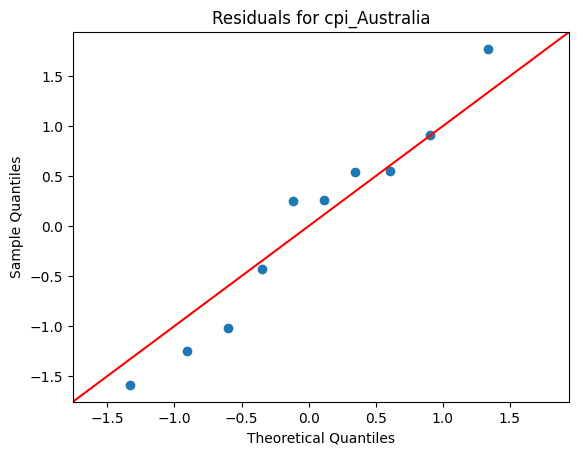

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              422.6
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    7.12e-09
Time:                        15:37:48   Log-Likelihood:                         -38.918
No. Observations:                  10   AIC:                                      79.84
Df Residuals:                       9   BIC:                                      80.14
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

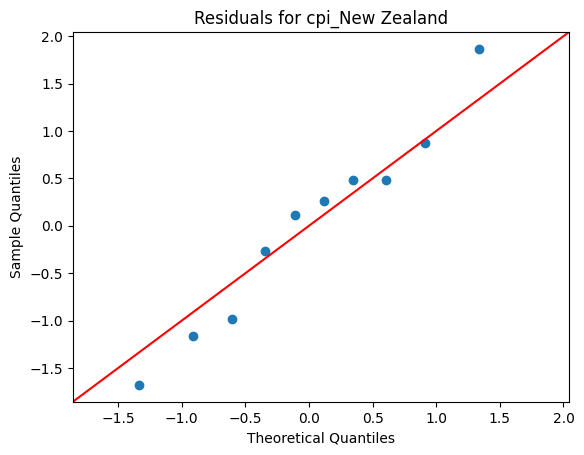

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              196.1
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    2.05e-07
Time:                        15:37:48   Log-Likelihood:                         -42.639
No. Observations:                  10   AIC:                                      87.28
Df Residuals:                       9   BIC:                                      87.58
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

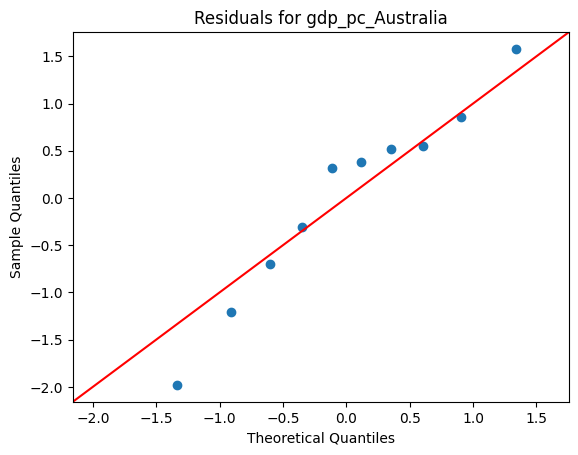

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              222.2
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    1.19e-07
Time:                        15:37:49   Log-Likelihood:                         -42.038
No. Observations:                  10   AIC:                                      86.08
Df Residuals:                       9   BIC:                                      86.38
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

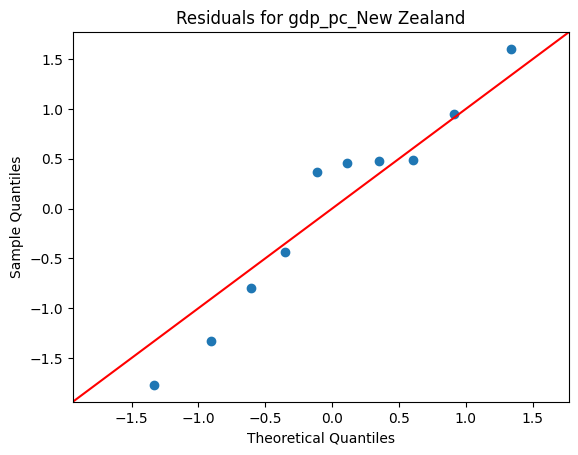

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                              550.3
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    2.22e-09
Time:                        15:37:49   Log-Likelihood:                         -37.623
No. Observations:                  10   AIC:                                      77.25
Df Residuals:                       9   BIC:                                      77.55
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

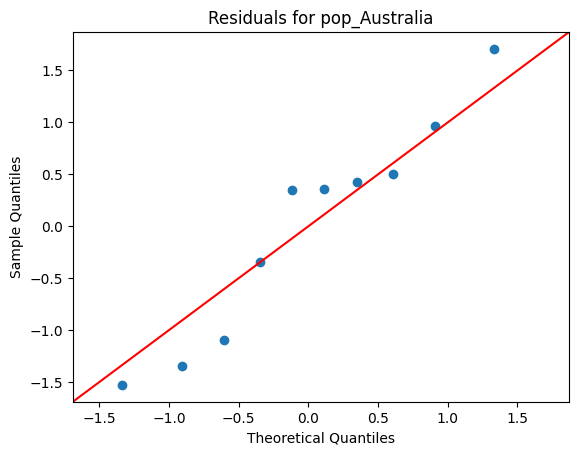

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              612.6
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    1.38e-09
Time:                        15:37:49   Log-Likelihood:                         -37.094
No. Observations:                  10   AIC:                                      76.19
Df Residuals:                       9   BIC:                                      76.49
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

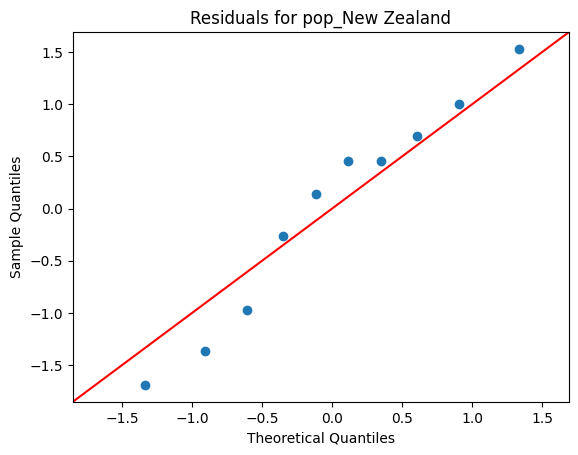

                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              802.6
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    4.14e-10
Time:                        15:37:49   Log-Likelihood:                         -35.761
No. Observations:                  10   AIC:                                      73.52
Df Residuals:                       9   BIC:                                      73.82
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


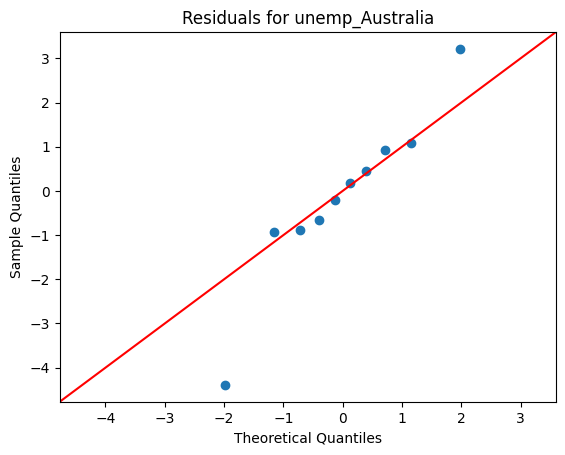

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              312.9
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    2.67e-08
Time:                        15:37:49   Log-Likelihood:                         -40.385
No. Observations:                  10   AIC:                                      82.77
Df Residuals:                       9   BIC:                                      83.07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

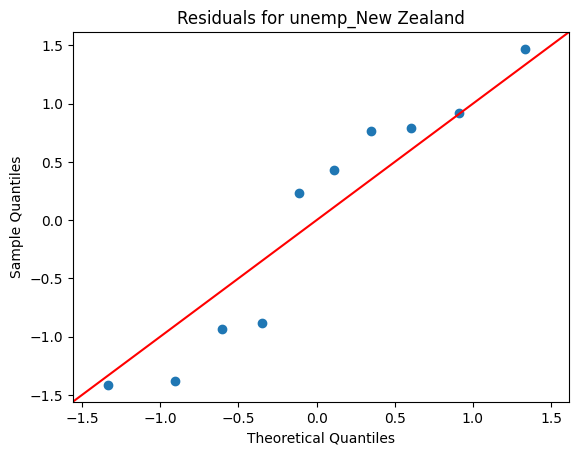

                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              1910.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    8.58e-12
Time:                        15:37:49   Log-Likelihood:                         -31.457
No. Observations:                  10   AIC:                                      64.91
Df Residuals:                       9   BIC:                                      65.22
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


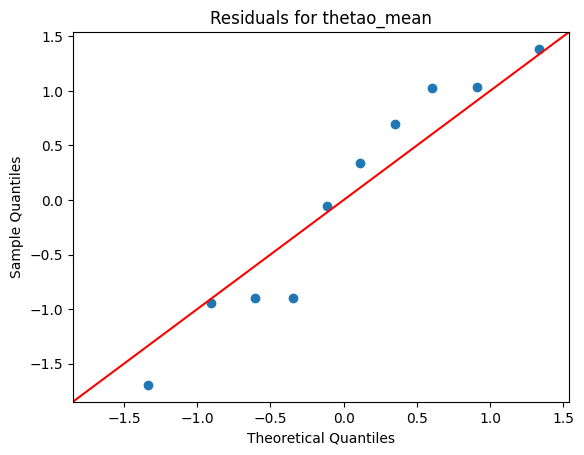

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              2187.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    4.68e-12
Time:                        15:37:49   Log-Likelihood:                         -30.784
No. Observations:                  10   AIC:                                      63.57
Df Residuals:                       9   BIC:                                      63.87
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

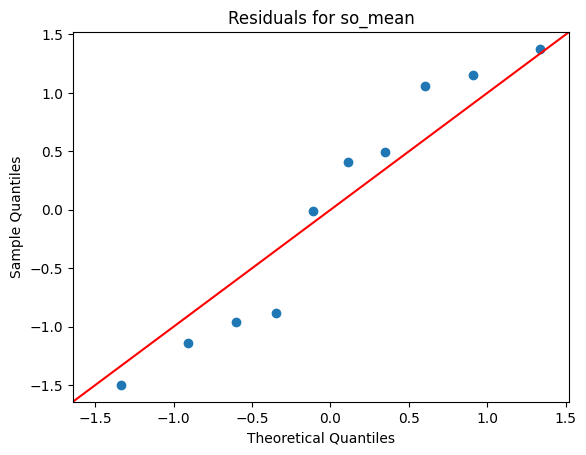

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              2388.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    3.16e-12
Time:                        15:37:49   Log-Likelihood:                         -30.347
No. Observations:                  10   AIC:                                      62.69
Df Residuals:                       9   BIC:                                      63.00
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

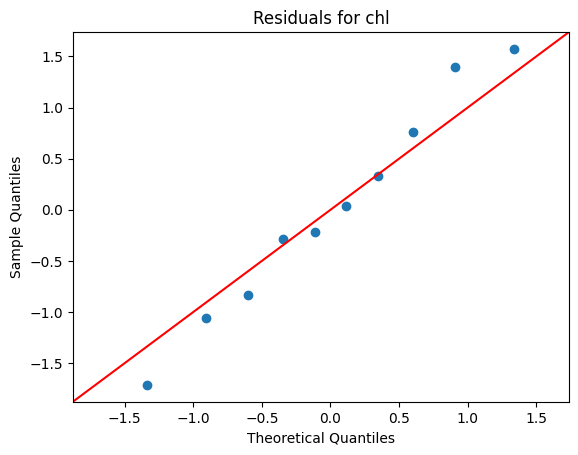

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              2608.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    2.13e-12
Time:                        15:37:50   Log-Likelihood:                         -29.907
No. Observations:                  10   AIC:                                      61.81
Df Residuals:                       9   BIC:                                      62.12
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

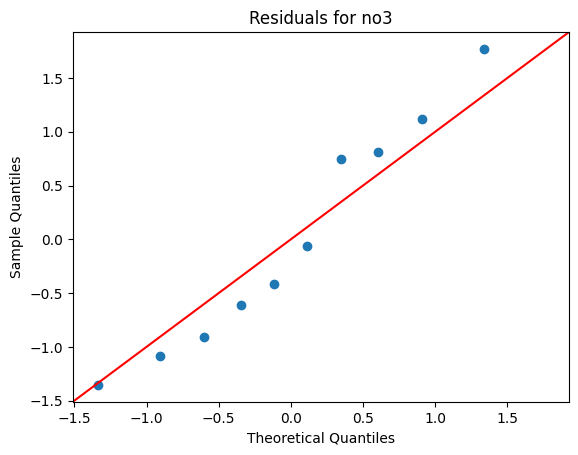

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              2864.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    1.40e-12
Time:                        15:37:50   Log-Likelihood:                         -29.441
No. Observations:                  10   AIC:                                      60.88
Df Residuals:                       9   BIC:                                      61.18
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

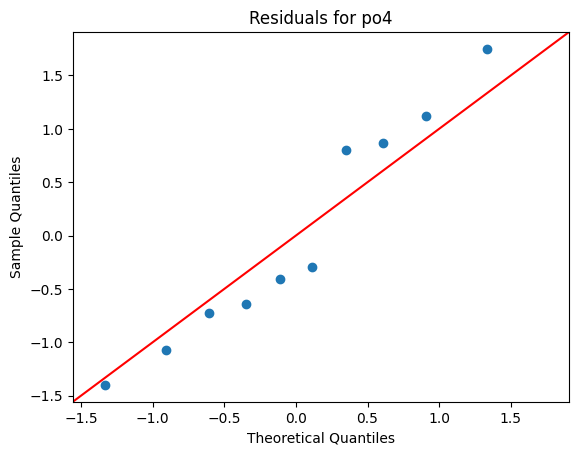

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              1509.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    2.47e-11
Time:                        15:37:50   Log-Likelihood:                         -32.631
No. Observations:                  10   AIC:                                      67.26
Df Residuals:                       9   BIC:                                      67.56
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

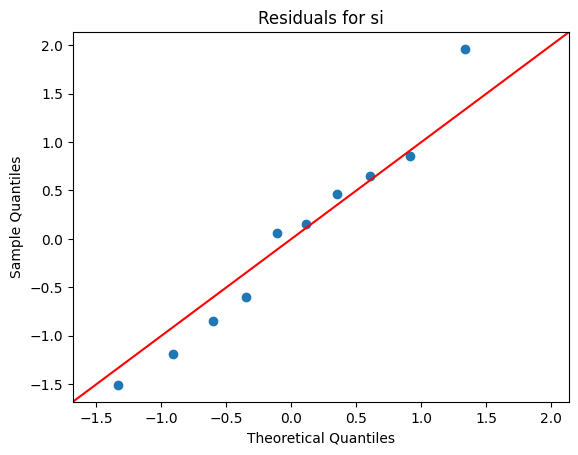

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              1994.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    7.08e-12
Time:                        15:37:50   Log-Likelihood:                         -31.243
No. Observations:                  10   AIC:                                      64.49
Df Residuals:                       9   BIC:                                      64.79
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

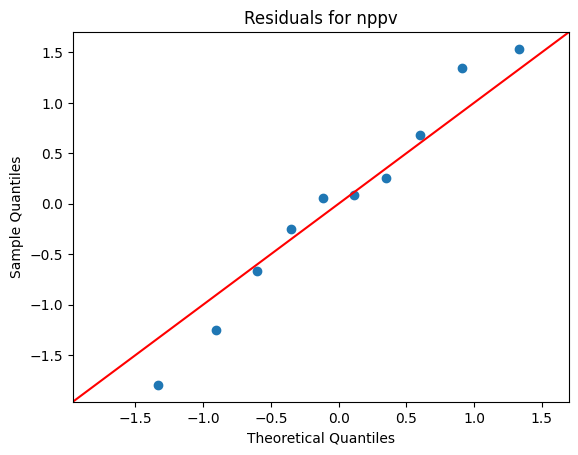

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              2249.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    4.13e-12
Time:                        15:37:50   Log-Likelihood:                         -30.645
No. Observations:                  10   AIC:                                      63.29
Df Residuals:                       9   BIC:                                      63.59
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

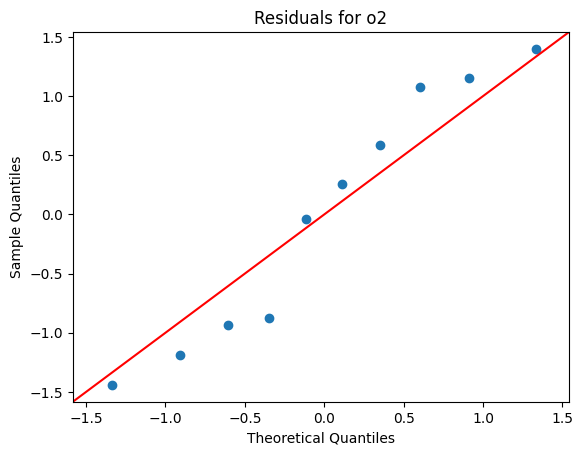

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              1585.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    1.98e-11
Time:                        15:37:50   Log-Likelihood:                         -32.387
No. Observations:                  10   AIC:                                      66.77
Df Residuals:                       9   BIC:                                      67.08
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

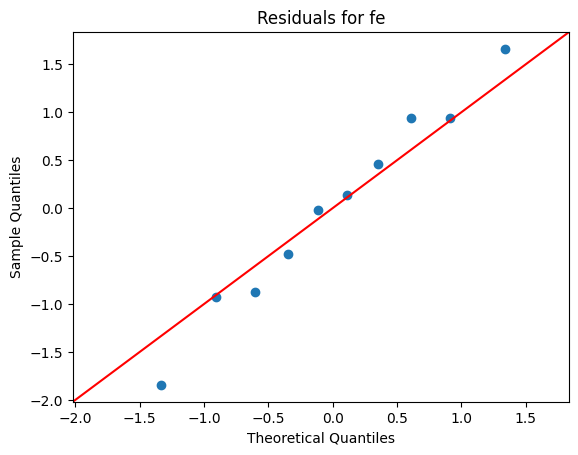

                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              2284.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    3.85e-12
Time:                        15:37:50   Log-Likelihood:                         -30.567
No. Observations:                  10   AIC:                                      63.13
Df Residuals:                       9   BIC:                                      63.44
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


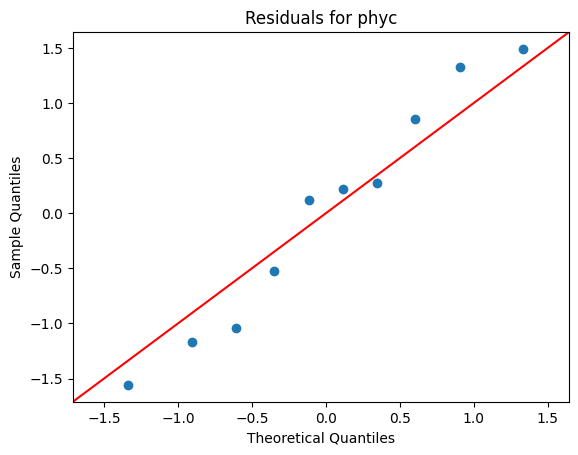

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              2199.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    4.57e-12
Time:                        15:37:50   Log-Likelihood:                         -30.757
No. Observations:                  10   AIC:                                      63.51
Df Residuals:                       9   BIC:                                      63.82
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

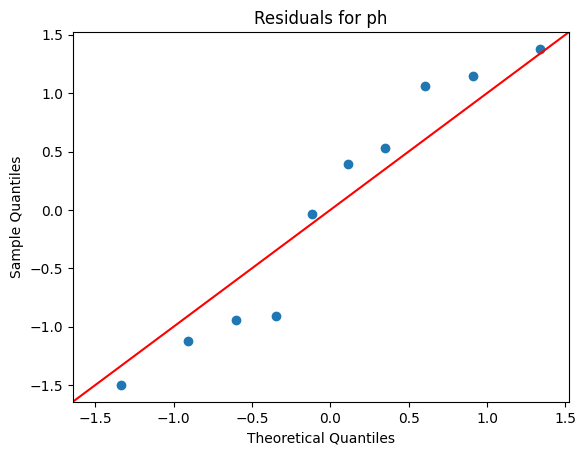

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              1548.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    2.20e-11
Time:                        15:37:51   Log-Likelihood:                         -32.502
No. Observations:                  10   AIC:                                      67.00
Df Residuals:                       9   BIC:                                      67.31
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

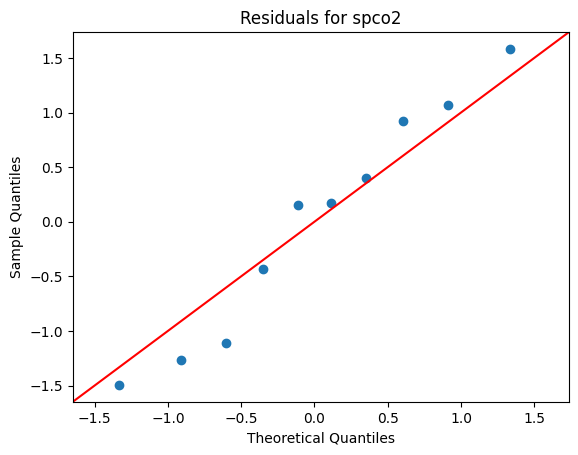

In [174]:
def ols_models(X, Y):
    for col in X.columns:
        ols = sm.OLS(Y, X[col])
        results = ols.fit()
        print(results.summary())
        fig = sm.qqplot(results.resid, stats.t, fit=True, line='45')
        plt.title(f"Residuals for {col}")
        plt.show()

ols_models(X81, Y81)

Create time lag models for capture and effort data. Since we have 10 data points, we test lag by 9 years.

In [175]:
lag = 9
lag_ranges = [(year - lag, year) for year in years]

lagged_capture = pd.DataFrame()

# Create each lagged column
for i, year in enumerate(years):
    start = year - lag  # Start of the 10-year range
    end = year  # End of the 10-year range
    # Filter and reset index to align rows
    lagged_capture[f"capture_{lag - i}"] = tot_capture81.loc[
        tot_capture81["Year"].between(start, end), "Capture"
    ].reset_index(drop=True)

lagged_capture.drop(columns=["capture_9"], inplace=True)

In [176]:
capture_model = sm.OLS(Y, lagged_capture).fit()
print(capture_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      S   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.491e+06
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    0.000492
Time:                        15:37:51   Log-Likelihood:                          26.358
No. Observations:                  10   AIC:                                     -34.72
Df Residuals:                       1   BIC:                                     -31.99
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


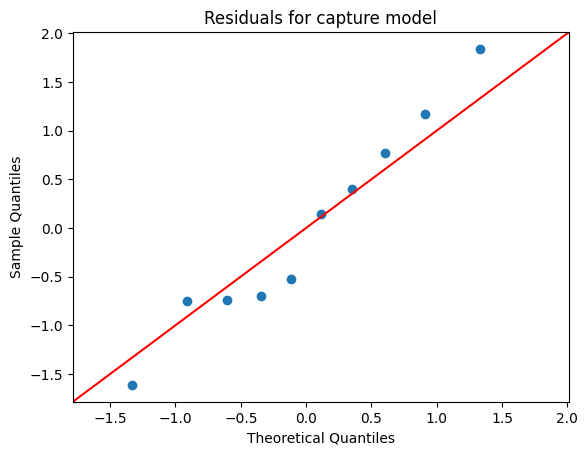

In [177]:
fig = sm.qqplot(capture_model.resid, stats.t, fit=True, line='45')
plt.title("Residuals for capture model")
plt.show()

In [178]:
effort81 = effort[effort["Country"].isin(countries81)]

In [179]:
effort81 = (
    effort81.groupby(["Year"])
    .sum()
    .reset_index()[["Year", "EffortCellReportedEff", "EffortCellIUUEff"]]
)

print(effort81)

    Year  EffortCellReportedEff  EffortCellIUUEff
0   1950           2.067599e+08      3.028342e+06
1   1951           2.131387e+08      3.184745e+06
2   1952           2.259360e+08      3.383863e+06
3   1953           2.382991e+08      3.556774e+06
4   1954           2.526115e+08      3.732459e+06
..   ...                    ...               ...
61  2011           2.245695e+09      1.082934e+07
62  2012           2.311008e+09      2.059434e+06
63  2013           2.376156e+09      1.908556e+06
64  2014           2.445531e+09      1.748838e+06
65  2015           2.524017e+09      1.572416e+06

[66 rows x 3 columns]
